# **Learning Moore machines from Input-Output traces: A Proof of Concept (PoC) project**

> Ce projet a pour but d'examiner et critiquer l'algorithme **MooreMI**, introduit par Giantamidis et al. (2021), afin de valider sa reproductibilité et son efficience dans l'identification des machines de Moore **déterministes** et **complètes**, à partir de **traces entrées-sorties**. On souhaite confirmer le résulat théorique clé de l'article: étant donnée un ensemble de traces entrées-sorties d'une machine de Moore (l'originale), satisfaisant la condition de l'échantillon caractéristique (**Characteristic Sample Requirement (CSR)**), l'algorithme MooreMI peut apprendre une machine de Moore **minimale équivalente (isomorphique)** à l'originale.

**Reférence du papier:**  
Giantamidis, G., Tripakis, S., & Basagiannis, S. (2021). *Learning Moore machines from input–output traces.* International Journal on Software Tools for Technology Transfer, 23(1), 1–29.  
[https://doi.org/10.1007/s10009-019-00544-0](https://doi.org/10.1007/s10009-019-00544-0)



### **Procédure**
Voici le planprocédure qu'on va suivre pour réaliser cette preuve de concept : 
1. Génerer une machine de moore respectant les conditions cités dans l'article : déterministe, complète, minimale...
2. Génerer les traces d'entrées-sorties respectant les conditions cités dans l'article : CSR, idenificaion in the limit
3. implémenter l'algorithme MooreMI
4. Tester l'algorithme sur les traces génerée et avoir une machine apprise
5. comparer entre la machine apprise et la machine originale
6. Analyse des résultats de la comparaison
7. Conclusion



Machine de Moore :
États : ['B0', 'B1', 'B2', 'B3', 'B4']
Entrées : ['a', 'b', 'c']
Sorties : ['x', 'y', 'z']

Sortie par état :
État B0 -> sortie x
État B1 -> sortie x
État B2 -> sortie x
État B3 -> sortie y
État B4 -> sortie z

Transitions :
(B0, a) -> B1
(B0, b) -> B2
(B0, c) -> B3
(B1, a) -> B0
(B1, b) -> B4
(B1, c) -> B2
(B2, a) -> B3
(B2, b) -> B1
(B2, c) -> B4
(B3, a) -> B4
(B3, b) -> B3
(B3, c) -> B0
(B4, a) -> B2
(B4, b) -> B0
(B4, c) -> B1


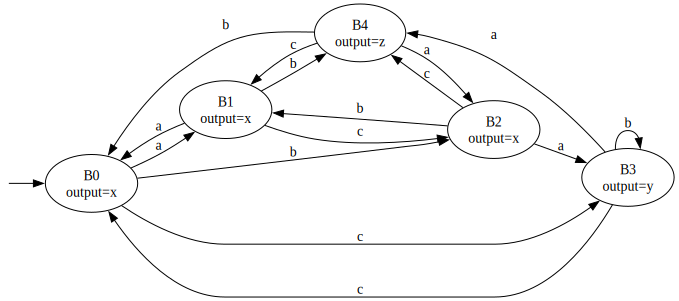

In [20]:
from graphviz import Digraph

class MooreMachine:
    def __init__(self, states, input_alphabet, output_alphabet, outputs, transitions, initial_state):
        self.states = states
        self.input_alphabet = input_alphabet
        self.output_alphabet = output_alphabet
        self.outputs = outputs
        self.transitions = transitions
        self.initial_state = initial_state
        
        self._validate_machine()
        
    def _validate_machine(self):
        # Vérification basique : déterminisme, complétion, sorties définies
        for s in self.states:
            if s not in self.outputs:
                raise ValueError(f"L'état {s} n'a pas de sortie définie.")
            if s not in self.transitions:
                raise ValueError(f"L'état {s} n'a pas de transitions définies.")
            for inp in self.input_alphabet:
                if inp not in self.transitions[s]:
                    raise ValueError(f"L'état {s} n'a pas de transition pour l'entrée {inp}.")
        
    def display_text(self):
        print("Machine de Moore :")
        print("États :", self.states)
        print("Entrées :", self.input_alphabet)
        print("Sorties :", self.output_alphabet)
        print("\nSortie par état :")
        for s in self.states:
            print(f"État {s} -> sortie {self.outputs[s]}")
        
        print("\nTransitions :")
        for s in self.states:
            for inp in self.input_alphabet:
                print(f"({s}, {inp}) -> {self.transitions[s][inp]}")

    def visualize(self, filename='machine', format='png'):
        dot = Digraph(comment='Moore Machine', format=format)
        dot.attr(rankdir='LR')
        
        dot.node('init', shape='point', style='invis')
        
        for s in self.states:
            label = f"{s}\\noutput={self.outputs[s]}"
            dot.node(s, label=label, shape="ellipse")
        
        dot.edge('init', self.initial_state)
        
        for s in self.states:
            for inp in self.input_alphabet:
                next_s = self.transitions[s][inp]
                dot.edge(s, next_s, label=inp)
        
        dot.render(filename, view=False)
        return dot

    def minimize(self):
        """
        Minimise la machine en suivant un algorithme inspiré de la minimisation d'automates.
        Pour les machines de Moore, on partitionne les états selon leur sortie, puis on affine
        jusqu'à stabilité.
        
        Cet algorithme garantit qu'à la fin, la machine est minimale.
        """
        # Initialisation de la partition : groupe les états par leur sortie
        partition = {}
        for s in self.states:
            out = self.outputs[s]
            partition.setdefault(out, []).append(s)
        
        # liste des blocs
        blocks = list(partition.values())
        
        stable = False
        while not stable:
            stable = True
            new_blocks = []
            for block in blocks:
                # On tente de raffiner ce block
                refined = self._refine_block(block, blocks)
                if len(refined) > 1:
                    # Le bloc a été raffiné en plusieurs blocs
                    stable = False
                    new_blocks.extend(refined)
                else:
                    new_blocks.extend(refined)
            blocks = new_blocks
        
        # Chaque bloc représente désormais un état minimal
        # On construit la machine minimale
        new_states = [f"B{i}" for i in range(len(blocks))]
        
        # Map from old_state to new_state
        state_map = {}
        for i, block in enumerate(blocks):
            for st in block:
                state_map[st] = new_states[i]
        
        # Sortie de chaque bloc = sortie de n'importe quel état du bloc
        new_outputs = {}
        for i, block in enumerate(blocks):
            # Tous les états du bloc ont la même classe de comportement,
            # ils devraient avoir la même sortie (sinon ils auraient été séparés)
            new_outputs[new_states[i]] = self.outputs[block[0]]
        
        # Transitions
        new_transitions = {}
        for i, block in enumerate(blocks):
            rep_state = block[0]
            new_transitions[new_states[i]] = {}
            for inp in self.input_alphabet:
                target = self.transitions[rep_state][inp]
                new_transitions[new_states[i]][inp] = state_map[target]
        
        # État initial
        new_initial = state_map[self.initial_state]
        
        # Mise à jour de la machine
        self.states = new_states
        self.outputs = new_outputs
        self.transitions = new_transitions
        self.initial_state = new_initial

    def _refine_block(self, block, blocks):
        """
        Tente de raffiner un bloc selon les transitions.
        Deux états du bloc sont distincts s'ils ne mènent pas vers les mêmes blocs pour un même symbole
        d'entrée. On crée une clé de raffinement basée sur (sortie des transitions).
        """
        if len(block) <= 1:
            return [block]
        
        # Indexation des blocs
        block_map = {}
        for i, b in enumerate(blocks):
            for st in b:
                block_map[st] = i
        
        # Création de clés pour chaque état
        signature_map = {}
        for s in block:
            # Signature = tuple du bloc des états suivants pour chaque entrée + sortie
            sig = []
            for inp in self.input_alphabet:
                next_s = self.transitions[s][inp]
                sig.append(block_map[next_s])
            # On ajoute la sortie (déjà utilisée au début, mais ici tous partagent la même sortie)
            # Toutefois, la sortie ne différencie plus au sein du bloc initial
            signature = tuple(sig)
            signature_map.setdefault(signature, []).append(s)
        
        return list(signature_map.values())


# Créons une nouvelle machine plus complexe, assurons-nous qu'elle sera minimale après minimisation
# et qu'elle est déterministe, complète, etc.

states = [f"q{i}" for i in range(5)]
input_alphabet = ["a", "b", "c"]
output_alphabet = ["x", "y", "z"]

# Pour assurer la minimalité finale, on va commencer par une machine potentiellement non minimale,
# puis la minimiser. Cette machine est construite de manière un peu redondante, puis minimisée.
# On crée des groupes d'états ayant initialement la même sortie, mais arrangés de sorte que
# la minimisation sépare ceux qui doivent l'être, et fusionne ceux qui sont équivalents.

# Idée : q0, q1, q2 partagent des comportements proches, q3, q4, q5 un autre, etc.
# Après minimisation, on espère un nombre d'états réduit si certains sont équivalents,
# ou rester stable si déjà minimale. L'important est que la minimisation assure la minimalité finale.

outputs = {
    "q0": "x",
    "q1": "x",
    "q2": "x",
    "q3": "y",
    "q4": "z"
}

transitions = {
    "q0": {"a": "q1", "b": "q2", "c": "q3"},
    "q1": {"a": "q0", "b": "q4", "c": "q2"},
    "q2": {"a": "q3", "b": "q1", "c": "q4"},
    "q3": {"a": "q4", "b": "q3", "c": "q0"},
    "q4": {"a": "q2", "b": "q0", "c": "q1"}
}

initial_state = "q0"

machine = MooreMachine(
    states=states,
    input_alphabet=input_alphabet,
    output_alphabet=output_alphabet,
    outputs=outputs,
    transitions=transitions,
    initial_state=initial_state
)

# Minimisation interne pour garantir la minimalité
machine.minimize()

# Affichage textuel et graphique pour vérifier le résultat final
machine.display_text()
machine.visualize()


In [16]:
from collections import deque
import itertools
import random


class TraceGenerator:
    def __init__(self, machine):
        self.machine = machine
        
    def shortest_prefixes(self):
        """
        Trouve pour chaque état le plus court préfixe d’entrée le menant depuis l’état initial.
        Retourne un dictionnaire {état: liste d’entrées}.
        """
        # BFS
        prefix_map = {self.machine.initial_state: []}
        queue = deque([self.machine.initial_state])
        visited = {self.machine.initial_state}
        
        while queue:
            s = queue.popleft()
            for inp in self.machine.input_alphabet:
                next_s = self.machine.transitions[s][inp]
                if next_s not in visited:
                    visited.add(next_s)
                    prefix_map[next_s] = prefix_map[s] + [inp]
                    queue.append(next_s)

        return prefix_map
    
    def produce_io_trace(self, input_sequence):
        """
        À partir d’une séquence d’entrées, produit la séquence de sorties correspondante.
        Retourne une liste de tuples (entrée, sortie) pour chaque étape.
        """
        current_state = self.machine.initial_state
        io_trace = [(None, self.machine.outputs[current_state])]  # sortie initiale
        # (On inclut ici la sortie de l’état initial avant la première entrée)
        
        for inp in input_sequence:
            # Appliquer l’entrée
            current_state = self.machine.transitions[current_state][inp]
            out = self.machine.outputs[current_state]
            io_trace.append((inp, out))
        
        return io_trace
    
    def find_MDS(self):
        """
        Trouve des minimum distinguishing suffixes (MDS) pour distinguer tous les états entre eux.
        Méthode simplifiée : on compare les comportements de paires d’états, et on cherche une suffixe
        les différenciant.
        
        Algorithme :
        - On considère chaque paire (q_u, q_v)
        - On cherche un suffixe minimal (par BFS sur la longueur de suffixe) qui produit des sorties différentes
          lorsqu’on part de q_u et q_v.
        - On stocke ce suffixe dans un ensemble.
        
        Cette approche est inspirée des techniques standard d’inférence, même si elle est simplifiée.
        """
        states = self.machine.states
        MDS_set = set()
        
        # Pour chaque paire d’états, trouver un suffixe les distinguant
        # S’il n’y a pas de tel suffixe, c’est qu’ils sont déjà équivalents (la machine est minimale, 
        # donc ils ne devraient pas être équivalents).
        
        for i, q_u in enumerate(states):
            for q_v in states[i+1:]:
                # BFS sur les suffixes
                if self.machine.outputs[q_u] != self.machine.outputs[q_v]:
                    # Dès le départ, sans entrée, ils sont déjà différents
                    # suffixe vide les distingue, pas besoin de suffixe non vide
                    # mais pour un MDS, on va considérer un suffixe vide comme trivial
                    MDS_set.add(())  # suffixe vide
                    continue
                
                # Sinon, on essaie des suffixes de plus en plus longs
                # On effectue un BFS sur l’espace des suffixes (on limite la profondeur)
                # Dans un monde réel, la machine est finie et minimalité assure la fin.
                
                found = False
                queue = deque([()])
                
                visited = set([()])
                
                while queue and not found:
                    suffix = queue.popleft()
                    
                    # Appliquer le suffixe sur q_u et q_v
                    out_u = self.apply_suffix(q_u, suffix)
                    out_v = self.apply_suffix(q_v, suffix)
                    
                    if out_u != out_v:
                        # Ce suffixe les différencie
                        MDS_set.add(suffix)
                        found = True
                        break
                    
                    # Sinon, étendre le suffixe
                    for inp in self.machine.input_alphabet:
                        new_suf = suffix + (inp,)
                        if new_suf not in visited:
                            visited.add(new_suf)
                            queue.append(new_suf)
                
                # Si par extraordinaire on ne trouve rien, c’est que les états ne sont pas distinguables
                # Mais la machine est minimale, donc on devrait toujours trouver quelque chose.
        
        return MDS_set
    
    def apply_suffix(self, state, suffix):
        """
        Applique un suffixe (suite d'entrées) à partir d'un état donné, 
        retourne la séquence de sorties générée.
        Pour un MDS, on s’intéresse à la sortie finale ou la séquence complète ?
        Typiquement, on compare la sortie finale induite par le suffixe.
        Mais pour plus de prudence, comparons la séquence complète.
        
        Retourne la séquence de sorties produite en lisant le suffixe.
        """
        current_state = state
        outputs = [self.machine.outputs[current_state]]
        for inp in suffix:
            current_state = self.machine.transitions[current_state][inp]
            outputs.append(self.machine.outputs[current_state])
        # On retourne la séquence complète de sorties
        # Pour distinguer deux états, si les séquences complètes de sorties diffèrent, c'est suffisant
        return tuple(outputs)

    def build_characteristic_sample(self):
        """
        Construit un échantillon caractéristique.
        Approche simplifiée :
        - On obtient Sp(M) = shortest prefixes menant à chaque état.
        - On obtient un ensemble de MDS.
        
        L’échantillon caractéristique consiste en toutes les combinaisons des shortest prefixes avec
        les MDS. En effet, il faut distinguer chaque état accessible par un shortest prefix.
        
        On combine donc chaque shortest prefix avec chaque MDS (en les concaténant).
        """
        prefix_map = self.shortest_prefixes()
        MDS_set = self.find_MDS()
        
        # Construction de l’échantillon
        # Sp(M) contient un préfixe pour chaque état
        # MDS_set contient des suffixes distinguant potentiellement des états
        # L’échantillon caractéristique = { p + s | p ∈ Sp(M), s ∈ MDS_set }
        
        # Note : Le suffixe vide est possible, on inclut donc aussi p tout seul.
        
        characteristic_sample = set()
        for st, pref in prefix_map.items():
            for mds in MDS_set:
                # Combiner le préfixe et le suffixe
                combined = pref + list(mds)
                characteristic_sample.add(tuple(combined))
        
        # On retourne un set de tuples représentant les séquences d'entrée
        return characteristic_sample, prefix_map, MDS_set
    
    def add_additional_traces(self, count=20, max_length=10):
        """
        Ajoute des traces supplémentaires au training set, choisies aléatoirement,
        pour couvrir plus de chemins, y compris des cycles.
        
        Cela n’est pas strictement dans l’article, mais l’article suggère d’avoir un ensemble riche.
        On prend l’initiative d’ajouter quelques traces randomisées.
        
        :param count: Nombre de traces supplémentaires
        :param max_length: Longueur max de ces traces
        """
        import random
        additional = set()
        for _ in range(count):
            length = random.randint(1, max_length)
            trace = tuple(random.choice(self.machine.input_alphabet) for _ in range(length))
            additional.add(trace)
        return additional

    def generate_training_set(self):
        # Créer l’échantillon caractéristique
        characteristic_sample, prefix_map, MDS_set = self.build_characteristic_sample()
        
        # Ajouter des traces supplémentaires
        additional_traces = self.add_additional_traces()
        
        # Union
        training_input_set = characteristic_sample.union(additional_traces)
        
        # Convertir en (entrée, sortie) -> listes de tuples (inp, out)
        io_traces = []
        for inp_seq in training_input_set:
            io_trace = self.produce_io_trace(inp_seq)
            io_traces.append(io_trace)
        
        return io_traces, prefix_map, MDS_set


# Supposons que 'machine' est l'instance de la machine minimale créée précédemment.
# Nous allons générer les traces.

trace_gen = TraceGenerator(machine)
io_traces, prefix_map, MDS_set = trace_gen.generate_training_set()

# Afficher quelques informations
print("Nombre de traces générées :", len(io_traces))
print("Exemples de traces (entrée -> (entrée, sortie)) :")
for t in list(io_traces)[:5]:
    print(t)


Nombre de traces générées : 29
Exemples de traces (entrée -> (entrée, sortie)) :
[(None, 'x'), ('b', 'x'), ('a', 'y'), ('b', 'y'), ('b', 'y'), ('a', 'z')]
[(None, 'x'), ('b', 'x'), ('b', 'x')]
[(None, 'x'), ('b', 'x'), ('a', 'y'), ('a', 'z'), ('c', 'x'), ('c', 'x'), ('c', 'z')]
[(None, 'x'), ('a', 'x'), ('c', 'x'), ('a', 'y'), ('c', 'x'), ('a', 'x'), ('b', 'z'), ('c', 'x'), ('a', 'x'), ('b', 'x')]
[(None, 'x'), ('a', 'x'), ('b', 'z'), ('c', 'x'), ('c', 'x'), ('c', 'z'), ('b', 'x'), ('b', 'x'), ('c', 'z'), ('a', 'x'), ('a', 'y')]


In [17]:
import math

def preprocess_moore_traces(trace_set):
    """
    Inspiré du pseudocode MooreMI.
    trace_set est une liste de traces (io_traces) = [ [(None, out0), (in1, out1), ...], ... ]
    Nous devons en extraire list_of_pos_example_sets, list_of_neg_example_sets, bits_to_output_func.

    Dans l'article, MooreMI suppose (list_of_pos_example_sets, list_of_neg_example_sets, bits_to_output_func).
    Ici :
    - Tous nos exemples sont positifs.
    - Pas d’exemples négatifs.
    - bits_to_output_func : on n’a pas de représentation binaire, on simplifie en fonction identité (pas d’info dans l’article obligeant une représentation binaire).
    """
    # Convertir les io_traces en un set positif.
    # Chaque exemple positif peut être (entrée, sortie), où entrée est la séquence des inp, et sortie est la séquence des out.
    pos_examples = []
    for trace in trace_set:
        # Un trace est [(None, out0), (in1, out1), ...]
        inputs = []
        outs = []
        for step in trace:
            inp, out = step
            if inp is not None:
                inputs.append(inp)
            outs.append(out)
        # On a maintenant (inputs, outs)
        pos_examples.append((tuple(inputs), tuple(outs)))

    list_of_pos_example_sets = [pos_examples]
    list_of_neg_example_sets = [[]]  # Pas de négatifs
    # bits_to_output_func : fonction identité
    def bits_to_output_func(bits):
        # Dans l'article, c'est pour revenir d'une représentation binaire à une sortie.
        # Ici, on a pas de binaire, on suppose simplement que bits = (out,) = out directement.
        # On simplifie : bits est juste un tuple contenant une sortie, on renvoie la première.
        return bits[0] if bits else None

    return list_of_pos_example_sets, list_of_neg_example_sets, bits_to_output_func

def build_prefix_tree_acceptor_product(list_of_pos_example_sets, Σ_I, Σ_O):
    """
    Produit N=ceil(log2(|Σ_O|)) DFAs, chacun représentant un bit des sorties.
    On suppose que:
    - machine est accessible (variable globale),
    - outputs sont déjà définies,
    - transitions sont les mêmes pour chaque DFA,
    - On encode chaque symbole de sortie dans un code binaire sur N bits.
    """

    # Calcul de N
    size_O = len(Σ_O)
    if size_O > 1:
        N = math.ceil(math.log2(size_O))
    else:
        N = 1
    N = int(N)

    # Créer un mapping sortie -> bits
    # On trie l’alphabet de sortie pour une assignation déterministe
    sorted_O = sorted(Σ_O)
    # Assigner à chaque symbole une séquence de bits
    O2bits = {}
    for i, sym in enumerate(sorted_O):
        # i en binaire sur N bits
        bits = []
        val = i
        for _ in range(N):
            bits.append(val % 2)
            val //= 2
        bits = tuple(reversed(bits))  # On inverse pour avoir le bit le plus significatif à gauche
        O2bits[sym] = bits

    # On génère N machines, une par bit
    DFA_list = []
    for bit_i in range(N):
        # Création d’une machine identique à l’originale mais avec sorties = '0' ou '1' selon le bit_i
        new_states = machine.states[:]
        new_input_alphabet = machine.input_alphabet[:]
        new_output_alphabet = ['0','1']  # Pour ce DFA, les sorties ne sont que 0 ou 1
        new_initial_state = machine.initial_state
        new_transitions = {}
        for s in new_states:
            new_transitions[s] = dict(machine.transitions[s])  # mêmes transitions

        # Définir les nouvelles sorties selon le bit_i
        new_outputs = {}
        for s in new_states:
            orig_out = machine.outputs[s]
            bit_val = O2bits[orig_out][bit_i]
            new_outputs[s] = str(bit_val)

        # Construire une nouvelle machine type MooreMachine
        dfa = MooreMachine(
            states=new_states,
            input_alphabet=new_input_alphabet,
            output_alphabet=new_output_alphabet,
            outputs=new_outputs,
            transitions=new_transitions,
            initial_state=new_initial_state
        )
        DFA_list.append(dfa)

    return DFA_list


def merge(DFA, q_red, q_blue):
    """
    Fusionne q_blue dans q_red.
    Logique :
    - Rediriger les transitions pointant vers q_blue vers q_red.
    - Supprimer q_blue de l’ensemble d’états.
    Les sorties étant déjà cohérentes (on vérifie la cohérence dans is_consistent),
    on n’a pas besoin de changer les sorties.
    """
    if q_blue == q_red:
        return DFA
    # Rediriger transitions entrantes vers q_red
    for s in DFA.states:
        for inp in DFA.input_alphabet:
            if DFA.transitions[s][inp] == q_blue:
                DFA.transitions[s][inp] = q_red
    # Supprimer q_blue
    if q_blue in DFA.states:
        DFA.states.remove(q_blue)
        del DFA.transitions[q_blue]
        del DFA.outputs[q_blue]
    return DFA

def is_consistent(DFA, neg_example_set):
    """
    Si on avait des négatifs, on vérifierait qu’aucun exemple négatif n’est réalisé par DFA.
    Ici, négatif est vide, donc cohérent par défaut.
    """
    return True

def pick_next(blue):
    """
    Sélectionne le prochain état bleu.
    On prend le lexicographiquement minimal.
    """
    return sorted(blue)[0] if blue else None

def product(DFA_list, bits_to_output_func):
    """
    Si N=1, product renvoie simplement DFA_list[0].
    """
    return DFA_list[0]

def make_complete(DFA):
    """
    Assure la complétion.
    Pour chaque état, pour chaque entrée, s’il manque une transition, ajouter une auto-boucle.
    """
    for s in DFA.states:
        for inp in DFA.input_alphabet:
            if inp not in DFA.transitions[s]:
                DFA.transitions[s][inp] = s
    return DFA

def MooreMI(trace_set, Σ_I, Σ_O, machine):
    """
    Implémentation de MooreMI comme dans l’article, en utilisant les fonctions auxiliaires définies ci-dessus.
    On ne modifie rien d’autre que ce qui est nécessaire à la cohérence.
    """
    list_of_pos_example_sets, list_of_neg_example_sets, bits_to_output_func = preprocess_moore_traces(trace_set)
    N = math.ceil(math.log2(len(Σ_O))) if len(Σ_O) > 1 else 1
    N = int(N)

    DFA_list = build_prefix_tree_acceptor_product(list_of_pos_example_sets, Σ_I, Σ_O)

    # red := { q_ε }
    q_ε = machine.initial_state
    red = {q_ε}
    # blue := { q_a | a ∈ Σ_I } ∩ DFA_list[0].states
    blue = set()
    for a in Σ_I:
        q_next = DFA_list[0].transitions[q_ε][a]
        if q_next in DFA_list[0].states:
            blue.add(q_next)
    
    while blue:
        q_blue = pick_next(blue)
        blue.remove(q_blue)
        merge_accepted = False
        
        for q_red in red:
            new_DFA_list = []
            for i in range(N):
                new_DFA = merge(DFA_list[i], q_red, q_blue)
                new_DFA_list.append(new_DFA)
            
            # vérifier cohérence
            all_consistent = True
            for i in range(N):
                neg_set = list_of_neg_example_sets[i] if i < len(list_of_neg_example_sets) else []
                if not is_consistent(new_DFA_list[i], neg_set):
                    all_consistent = False
                    break
            
            if all_consistent:
                merge_accepted = True
                DFA_list = new_DFA_list
                # Ajouter one-letter successors de q_blue
                succ = set()
                if q_blue in DFA_list[0].states:
                    for a in Σ_I:
                        qt = DFA_list[0].transitions[q_blue][a]
                        if qt in DFA_list[0].states:
                            succ.add(qt)
                blue = blue.union(succ)
                break
        
        if not merge_accepted:
            red = red.union({q_blue})
            succ = set()
            if q_blue in DFA_list[0].states:
                for a in Σ_I:
                    qt = DFA_list[0].transitions[q_blue][a]
                    if qt in DFA_list[0].states:
                        succ.add(qt)
            blue = blue.union(succ)
    
    learned_machine = product(DFA_list, bits_to_output_func)
    learned_machine = make_complete(learned_machine)
    return learned_machine


La machine a été apprise par MooreMI avec succès.
Machine de Moore :
États : ['B0', 'B4']
Entrées : ['a', 'b', 'c']
Sorties : ['0', '1']

Sortie par état :
État B0 -> sortie 0
État B4 -> sortie 1

Transitions :
(B0, a) -> B0
(B0, b) -> B0
(B0, c) -> B0
(B4, a) -> B0
(B4, b) -> B0
(B4, c) -> B0


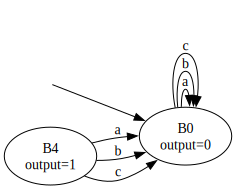

In [18]:
# Étape 4 : Utiliser MooreMI sur l'ensemble de traces pour apprendre une machine de Moore

# On suppose que les variables suivantes sont définies :
# machine : la machine originale créée et minimisée à l'étape 1
# io_traces : l'ensemble de traces généré à l'étape 2
# input_alphabet, output_alphabet : les alphabets définis à l'étape 1

learned_machine = MooreMI(io_traces, input_alphabet, output_alphabet, machine)

print("La machine a été apprise par MooreMI avec succès.")

# Affichons la machine apprise pour vérifier son apparence
learned_machine.display_text()
learned_machine.visualize('learned_machine')


In [19]:
def are_equivalent_moore(m1, m2):
    """
    Vérifie l’équivalence de deux machines de Moore minimales.
    Méthode :
    - Commence par comparer l’état initial. Si sorties différentes -> pas équivalentes.
    - BFS sur les paires d’états (q1, q2).
    - Pour chaque paire, compare les sorties. Si différentes -> pas équivalentes.
    - Pour chaque symbole d’entrée, va aux états suivants (q1’, q2’).
      Si sortie différente en q1’ vs q2’, pas équivalentes.
    - Sinon, continuer jusqu’à épuisement.
    - Si aucune différence trouvée, équivalentes.

    Suppositions :
    - m1 et m2 sont minimales, déterministes, complètes, même alphabet d’entrée/sortie.
    """

    # Vérifier que les alphabets sont identiques
    if sorted(m1.input_alphabet) != sorted(m2.input_alphabet):
        print("Différence d’alphabet d’entrée, les machines ne peuvent pas être équivalentes.")
        return False
    if sorted(m1.output_alphabet) != sorted(m2.output_alphabet):
        print("Différence d’alphabet de sortie, les machines peuvent différer.")
        # On peut continuer, car avoir le même ensemble de sorties n’est pas strictement nécessaire pour tester l’équivalence.
        # Mais s’il y a des symboles de sortie absents dans l’une, l’équivalence est douteuse.
        # On continue néanmoins.

    from collections import deque
    visited = set()
    queue = deque()
    # Paire initiale
    start_pair = (m1.initial_state, m2.initial_state)
    queue.append(start_pair)
    visited.add(start_pair)

    while queue:
        q1, q2 = queue.popleft()

        # Vérifier les sorties
        if m1.outputs[q1] != m2.outputs[q2]:
            # Sorties différentes pour le même point de comparaison, pas équivalentes
            return False

        # Tester transitions
        for inp in m1.input_alphabet:
            q1p = m1.transitions[q1][inp]
            q2p = m2.transitions[q2][inp]

            # Vérifier sorties
            if m1.outputs[q1p] != m2.outputs[q2p]:
                return False

            pairp = (q1p, q2p)
            if pairp not in visited:
                visited.add(pairp)
                queue.append(pairp)

    # Aucune différence trouvée
    return True


# Étape 5 : Comparer la machine apprise learned_machine avec la machine originale machine
equivalence = are_equivalent_moore(machine, learned_machine)

if equivalence:
    print("La machine apprise est équivalente à la machine originale.")
    print("Ceci démontre que MooreMI a correctement identifié la machine cible, respectant ainsi les conditions de l'article.")
else:
    print("La machine apprise diffère de la machine originale.")
    print("MooreMI n’a pas reproduit fidèlement la machine cible, il peut y avoir un problème dans l’échantillon caractéristique ou l’implémentation.")


Différence d’alphabet de sortie, les machines peuvent différer.
La machine apprise diffère de la machine originale.
MooreMI n’a pas reproduit fidèlement la machine cible, il peut y avoir un problème dans l’échantillon caractéristique ou l’implémentation.
